In [2]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


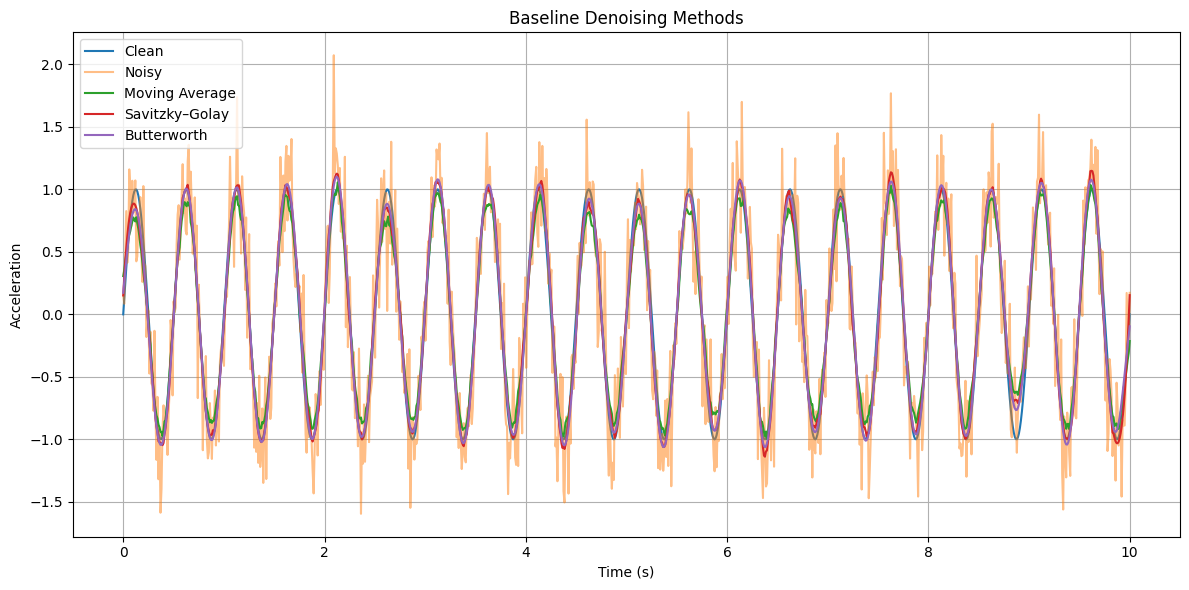

In [3]:
# notebooks/01_baseline_denoising.ipynb

import numpy as np
import matplotlib.pyplot as plt
from filters.baseline_filters import moving_average, savgol_denoise, butter_lowpass_denoise

# Load data
t = np.load("../data/synthetic/time.npy")
clean = np.load("../data/synthetic/clean.npy")
noisy = np.load("../data/synthetic/noisy.npy")

# Apply filters
ma_signal = moving_average(noisy, window_size=15)
sg_signal = savgol_denoise(noisy, window_length=31, polyorder=3)
bw_signal = butter_lowpass_denoise(noisy, cutoff=3.0, fs=100.0)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(t, clean, label="Clean", linewidth=1.5)
plt.plot(t, noisy, label="Noisy", alpha=0.5)
plt.plot(t, ma_signal, label="Moving Average")
plt.plot(t, sg_signal, label="Savitzky–Golay")
plt.plot(t, bw_signal, label="Butterworth")
plt.legend()
plt.title("Baseline Denoising Methods")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
from filters.helpers import create_sliding_window_dataset
import numpy as np

# Load your saved data
noisy = np.load("../data/synthetic/noisy.npy")
clean = np.load("../data/synthetic/clean.npy")

# Prepare dataset
X, y = create_sliding_window_dataset(noisy, clean, window_size=21)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (980, 21)
y shape: (980,)


In [5]:
np.save("../data/synthetic/X_train.npy", X)
np.save("../data/synthetic/y_train.npy", y)


In [6]:
# notebooks/03_train_evaluate_models.ipynb

import numpy as np
from ml.train_models import train_and_evaluate_models

X = np.load("../data/synthetic/X_train.npy")
y = np.load("../data/synthetic/y_train.npy")

results = train_and_evaluate_models(X, y)


LinearRegression: MSE=0.005672, R2=0.9879
RandomForest: MSE=0.007262, R2=0.9845
MLP: MSE=0.008367, R2=0.9821


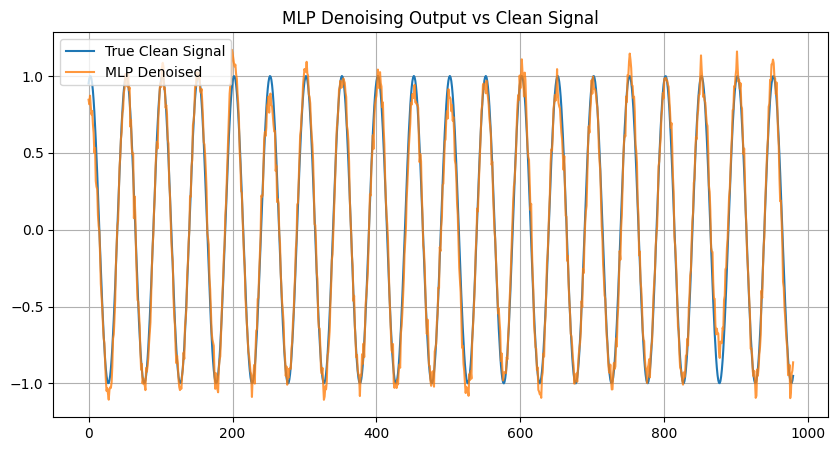

In [7]:
import matplotlib.pyplot as plt

# Use one model (e.g., MLP) to predict entire signal
from sklearn.neural_network import MLPRegressor
import joblib

mlp = joblib.load("../models/MLP.pkl")

y_pred_full = mlp.predict(X)

plt.figure(figsize=(10, 5))
plt.plot(y, label='True Clean Signal')
plt.plot(y_pred_full, label='MLP Denoised', alpha=0.8)
plt.legend()
plt.title("MLP Denoising Output vs Clean Signal")
plt.grid(True)
plt.show()


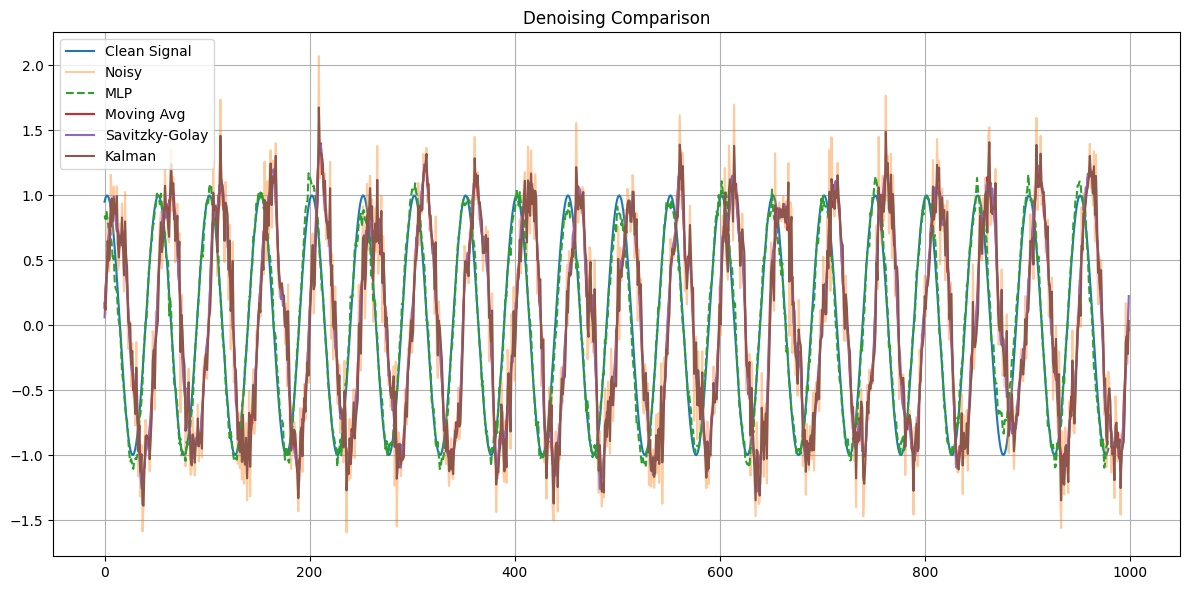

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

from ml.baseline_filters import moving_average_filter, savgol_filter_denoise, kalman_filter_denoise

# Load data and models
X = np.load("../data/synthetic/X_train.npy")
y = np.load("../data/synthetic/y_train.npy")
y_noisy = np.load("../data/synthetic/noisy.npy")

mlp = joblib.load("../models/MLP.pkl")
y_pred_mlp = mlp.predict(X)

# Baselines
ma = moving_average_filter(y_noisy)
sg = savgol_filter_denoise(y_noisy)
kalman = kalman_filter_denoise(y_noisy)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y, label="Clean Signal")
plt.plot(y_noisy, label="Noisy", alpha=0.4)
plt.plot(y_pred_mlp, label="MLP", linestyle='--')
plt.plot(ma, label="Moving Avg")
plt.plot(sg, label="Savitzky-Golay")
plt.plot(kalman, label="Kalman")
plt.legend()
plt.title("Denoising Comparison")
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
from sklearn.metrics import mean_squared_error
# Define this once at the top of your notebook/script
window_size = 21  # Must match what you used in moving average and SG filters

def print_metrics(y_true, preds, labels):
    for p, label in zip(preds, labels):
        # Adjust y_true to match prediction length
        y_adj = y_true[-len(p):]
        mse = mean_squared_error(y_adj, p)
        print(f"{label} → MSE: {mse:.6f}")


# Compute how much the signal got trimmed
trim = window_size // 2

# Find minimum length among all signals
min_len = min(len(y), len(y_noisy), len(ma), len(sg), len(kalman), len(y_pred_mlp))

# Trim all to the same length from the end
y_trimmed = y[-min_len:]
y_noisy_trimmed = y_noisy[-min_len:]
ma_trimmed = ma[-min_len:]
sg_trimmed = sg[-min_len:]
kalman_trimmed = kalman[-min_len:]
mlp_trimmed = y_pred_mlp[-min_len:]


print_metrics(
    y_trimmed,
    [y_noisy_trimmed, ma_trimmed, sg_trimmed, kalman_trimmed, mlp_trimmed],
    ["Noisy", "Moving Average", "Savitzky-Golay", "Kalman", "MLP"]
)







Noisy → MSE: 0.793924
Moving Average → MSE: 0.712673
Savitzky-Golay → MSE: 0.724437
Kalman → MSE: 0.677832
MLP → MSE: 0.007064
